In [1]:
# Import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [2]:
# Read the data
reports = pd.read_csv("scraped data for LDA/geopolitics1y.csv")
reports.head()
reports.info()

# Our spaCy model:
nlp = en_core_web_md.load()

# Tags we want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []

reports['Description'] = reports['Description'].astype(str)
for description in nlp.pipe(reports['Description']):
   proj_tok = [token.lemma_.lower() for token in description if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

# Add tokens to new column
reports['tokens'] = tokens
reports['tokens']

# Create dictionary
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(reports['tokens'])
print(dictionary.token2id)

# Filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in reports['tokens']]

# LDA model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2377 entries, 0 to 2376
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Time         2377 non-null   object
 1   Title        2377 non-null   object
 2   Description  2377 non-null   object
 3   Link         2377 non-null   object
 4   Datetime     2377 non-null   object
dtypes: object(5)
memory usage: 93.0+ KB
{'aide': 0, 'americans': 1, 'biden': 2, 'bill': 3, 'dour': 4, 'economy': 5, 'effort': 6, 'election': 7, 'joe': 8, 'lift': 9, 'major': 10, 'mood': 11, 'political': 12, 'president': 13, 'seek': 14, 'shore': 15, 'speech': 16, 'weakness': 17, 'wednesday': 18, 'work': 19, 'action': 20, 'announce': 21, 'block': 22, 'cancel': 23, 'condemn': 24, 'court': 25, 'debt': 26, 'friday': 27, 'loan': 28, 'new': 29, 'plan': 30, 'provide': 31, 'relief': 32, 'reuters': 33, 'ruling': 34, 'student': 35, 'supreme': 36, 'wake': 37, 'washington': 38, 'benefit': 39, 'campaign': 40, 'de

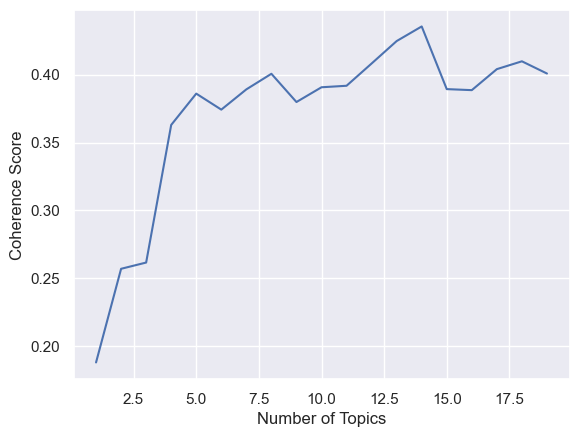

In [3]:
# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = reports['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [4]:
coherence_lda = cm.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.40076366998444235


In [5]:
# Optimal model
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=14, workers = 4, passes=100)

In [6]:
# Print topics
lda_model.print_topics(-1)

[(0,
  '0.058*"governor" + 0.057*"republican" + 0.037*"presidential" + 0.035*"ron" + 0.035*"desantis" + 0.034*"florida" + 0.028*"nomination" + 0.022*"trump" + 0.021*"state" + 0.020*"donald"'),
 (1,
  '0.067*"biden" + 0.062*"president" + 0.059*"joe" + 0.039*"white" + 0.039*"say" + 0.038*"house" + 0.036*"reuters" + 0.031*"washington" + 0.015*"thursday" + 0.014*"plan"'),
 (2,
  '0.043*"trump" + 0.040*"donald" + 0.037*"president" + 0.036*"capitol" + 0.029*"attack" + 0.023*"reuters" + 0.022*"investigate" + 0.022*"washington" + 0.022*"election" + 0.017*"say"'),
 (3,
  '0.045*"trump" + 0.037*"donald" + 0.030*"president" + 0.027*"claim" + 0.021*"reuters" + 0.021*"election" + 0.018*"state" + 0.017*"trial" + 0.017*"new" + 0.015*"republican"'),
 (4,
  '0.053*"election" + 0.043*"president" + 0.034*"republicans" + 0.029*"reuters" + 0.027*"midterm" + 0.023*"trump" + 0.023*"biden" + 0.023*"party" + 0.022*"tuesday" + 0.021*"joe"'),
 (5,
  '0.054*"trump" + 0.044*"donald" + 0.042*"president" + 0.026*"ne

In [7]:
# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [8]:
# Save the report
pyLDAvis.save_html(lda_display, 'saved html/geopolitics1y.html')

              x         y  topics  cluster       Freq
topic                                                
5      0.205884 -0.031210       1        1  12.187847
1     -0.103041  0.070557       2        1  11.437622
9     -0.179067  0.044629       3        1   9.866101
2      0.159042  0.035110       4        1   8.734237
4     -0.011217  0.211010       5        1   7.944161
10    -0.165949 -0.047204       6        1   7.788874
8     -0.019458 -0.225317       7        1   6.963032
0      0.049631  0.086703       8        1   6.487861
3      0.201545  0.018661       9        1   5.675155
11    -0.213075 -0.011092      10        1   5.658223
13     0.062986 -0.082145      11        1   5.300859
12    -0.124723  0.020118      12        1   5.168674
6      0.097652  0.122402      13        1   3.630061
7      0.039791 -0.212222      14        1   3.157294


Text(0, 0.5, 'Y Coordinate')

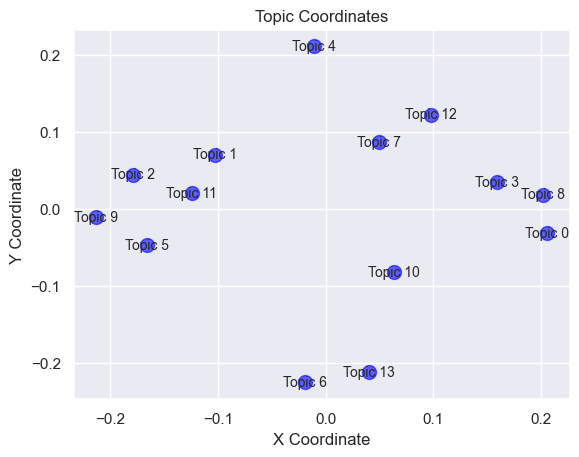

In [9]:
# Access the topic coordinates
topic_coordinates = lda_display.topic_coordinates

# Access the ordering of topics in the visualization
topic_order = lda_display.topic_order
print (topic_coordinates)

# Convert topic coordinates to NumPy array
topic_coordinates_array = topic_coordinates.values

# Create a scatter plot of the topic coordinates
plt.scatter(topic_coordinates_array[:, 0], topic_coordinates_array[:, 1], marker='o', c='blue', s=100, alpha=0.6)

# Add labels to the scatter plot
for topic, (x, y, *_) in enumerate(topic_coordinates_array):
    plt.text(x, y, f'Topic {topic}', fontsize=10, ha='center', va='center')

# Set plot title and axis labels
plt.title('Topic Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

In [10]:
reports['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(reports['Description']))]
reports.topic.value_counts()

topic
1     560
0     413
2     324
4     227
3     177
5     175
9     145
8      96
6      76
10     71
7      56
11     25
12     16
13     16
Name: count, dtype: int64

In [11]:
# Associate topics with datetime
reports['topic'] = [sorted(lda_model[corpus[text]], key=lambda x: x[1], reverse=True)[0][0] for text in range(len(reports['Description']))]
reports['topic'] = reports['topic'].astype(int)

# Merge topics with corresponding datetime
topics = lda_model.print_topics(num_topics=14, num_words=5)
topics_dict = {topic[0]: topic[1] for topic in topics}
reports['topic_words'] = reports['topic'].map(topics_dict)

# Resulting DataFrame with topics associated with datetime
print(reports[['Datetime', 'topic', 'topic_words']])

                       Datetime  topic   
0     2023-06-30 20:53:00+00:00      4  \
1     2023-06-30 20:31:00+00:00      8   
2     2023-06-30 20:26:00+00:00      8   
3     2023-06-30 19:21:00+00:00     12   
4     2023-06-30 18:50:00+00:00      6   
...                         ...    ...   
2372  2022-07-01 18:57:00+00:00     13   
2373  2022-07-01 04:42:00+00:00     11   
2374  2022-07-01 01:02:00+00:00      2   
2375  2022-07-01 00:43:00+00:00      9   
2376  2022-07-01 00:05:00+00:00      1   

                                            topic_words  
0     0.053*"election" + 0.043*"president" + 0.034*"...  
1     0.042*"court" + 0.027*"supreme" + 0.027*"state...  
2     0.042*"court" + 0.027*"supreme" + 0.027*"state...  
3     0.041*"senate" + 0.038*"leader" + 0.028*"repub...  
4     0.044*"trump" + 0.032*"donald" + 0.025*"republ...  
...                                                 ...  
2372  0.049*"election" + 0.041*"state" + 0.037*"abor...  
2373  0.031*"climate" + 0.025*"

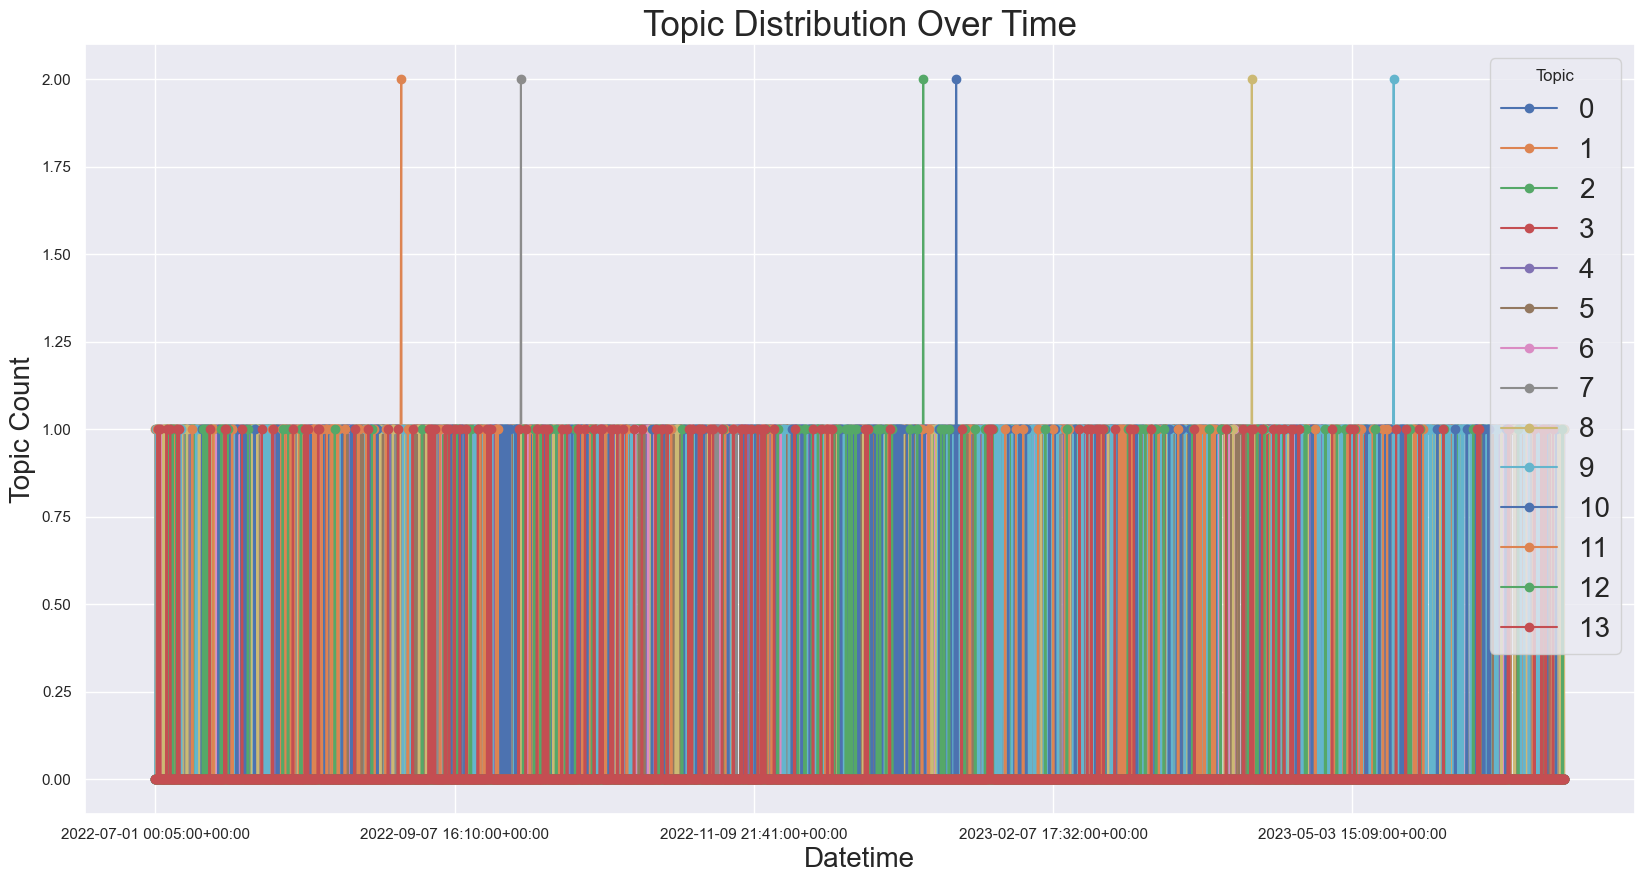

In [14]:
# Group the data by datetime and topic
grouped_data = reports.groupby(['Datetime', 'topic']).size().unstack().fillna(0)

# Plotting the distribution of topics over time
grouped_data.plot(kind='line', figsize=(20, 10), marker='o')

# Customize the plot
plt.title('Topic Distribution Over Time', fontsize=25)
plt.xlabel('Datetime', fontsize=20)
plt.ylabel('Topic Count', fontsize=20)
plt.legend(title='Topic', loc='upper right', fontsize=20)

# Show the plot
plt.show()